In [1]:
!pip install --quiet pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 47.0 MB/s eta 0:00:00


In [2]:
import os
import random
import torch
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import PIL
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning as pl
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
import cv2
from google.colab.patches import cv2_imshow

In [3]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp '/content/drive/MyDrive/Projects/Machine Learning for Healthcare/2nd phase/Dataset/ORCA_Augmented' -r '/content/'

In [6]:
folder_path = '/content/ORCA_Augmented'

In [7]:

trainA_folder = os.path.join(folder_path, "Original_RGB")
trainA_files = os.listdir(trainA_folder)
trainA_paths = [os.path.join(trainA_folder, file) for file in trainA_files]
print(len(trainA_paths))

# Get list of all image filenames in trainB folder
trainB_folder = os.path.join(folder_path, "Mask_RGB")
trainB_files = os.listdir(trainB_folder)
trainB_paths = [os.path.join(trainB_folder, file) for file in trainB_files]
print(len(trainB_paths))

# Combine trainA and trainB paths into a DataFrame
train_df = pd.DataFrame({"trainA": trainA_paths, "trainB": trainB_paths})

760
760


In [8]:
folder_path = '/content/ORCA_Augmented/Test'

In [9]:

testA_folder = os.path.join(folder_path, "Original")
testA_files = os.listdir(testA_folder)
testA_paths = [os.path.join(testA_folder, file) for file in testA_files]
print(len(testA_paths))

# Get list of all image filenames in trainB folder
testB_folder = os.path.join(folder_path, "Mask")
testB_files = os.listdir(testB_folder)
testB_paths = [os.path.join(testB_folder, file) for file in testB_files]
print(len(testB_paths))

# Combine trainA and trainB paths into a DataFrame
test_df = pd.DataFrame({"testA": testA_paths, "testB": testB_paths})

40
40


In [10]:
def show_sample(idx=0):
  image1 = cv2.imread(trainA_paths[idx])
  image1 = cv2.resize(image1, (224, 224))
  image2 = cv2.imread(trainB_paths[idx])
  image2 = cv2.resize(image2, (224, 224))
  result = cv2.hconcat([image1, image2])
  cv2_imshow(result)

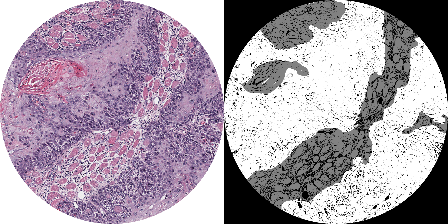

In [11]:
show_sample(10)

In [12]:
def has_three_channels(image_path):
    with Image.open(image_path) as img:
        return img.mode == 'RGB'

# Filter the DataFrame to keep only the images with 3 channels
train_df = train_df[train_df['trainA'].apply(has_three_channels)]
train_df = train_df[train_df['trainB'].apply(has_three_channels)]

In [13]:

# Filter the DataFrame to keep only the images with 3 channels
test_df = test_df[test_df['testA'].apply(has_three_channels)]
test_df = test_df[test_df['testB'].apply(has_three_channels)]


In [14]:
train_df, val_df = train_test_split(train_df,test_size=0.1)
# train_df, test_df = train_test_split(train_df, test_size = 0.1)

In [15]:
train_df.shape

(684, 2)

In [16]:
val_df.shape

(76, 2)

In [17]:
test_df.shape

(40, 2)

In [18]:

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [19]:

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


In [20]:

class UNetDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        imgA = row['trainA']
        imgB = row['trainB']

        # load the image and apply transform
        imgA = PIL.Image.open(imgA)
        imgA = self.transform(imgA)

        imgB = PIL.Image.open(imgB)
        imgB = self.transform(imgB)

        return dict(
        imgA = imgA,
        imgB = imgB)

In [21]:
class UNetDataModule(pl.LightningDataModule):
  def __init__(self,train_df : pd.DataFrame,val_df : pd.DataFrame,test_df : pd.DataFrame,
               train_transform : train_transform,val_transform : val_transform,batch_size : int = 8):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.val_df = val_df
    self.train_transform = train_transform
    self.val_transform = val_transform


  def setup(self,stage=None):
    self.train_dataset = UNetDataset(self.train_df,self.train_transform)
    self.val_dataset = UNetDataset(self.val_df,self.val_transform)
    self.test_dataset = UNetDataset(self.test_df,self.val_transform)

  def train_dataloader(self):
    return DataLoader(self.train_dataset,batch_size = self.batch_size,shuffle=True,num_workers=4)

  def val_dataloader(self):
    return DataLoader(self.val_dataset,batch_size = self.batch_size,num_workers=4)

  def test_dataloader(self):
    return DataLoader(self.test_dataset,batch_size = self.batch_size,num_workers=4)

In [22]:

BATCH_SIZE = 32
N_EPOCHS = 10

data_module = UNetDataModule(train_df,val_df,test_df,train_transform,
                            val_transform,batch_size = BATCH_SIZE)
data_module.setup()

In [23]:
# Building UNET

class DownSample(nn.Module):
    def __init__(self, Input_Channels, Output_Channels):
        super(DownSample, self).__init__()
        # nn.Conv2d(in_channel, out_channel, kernel, stride, padding)
        self.model = nn.Sequential(
                     nn.Conv2d(Input_Channels, Output_Channels, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2)
                     )

    def forward(self, x):
        down = self.model(x)
        return down


class Upsample(nn.Module):
    def __init__(self, Input_Channels, Output_Channels):
        super(Upsample, self).__init__()

        self.model = nn.Sequential(
                     nn.ConvTranspose2d(Input_Channels, Output_Channels, 4, 2, 1, bias=False),
                     nn.InstanceNorm2d(Output_Channels),
                     nn.ReLU(inplace=True),)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x


class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()

        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)
        self.down5 = DownSample(512, 512)
        self.down6 = DownSample(512, 512)
        self.down7 = DownSample(512, 512)
        self.down8 = DownSample(512, 512)

        self.up1 = Upsample(512, 512)
        self.up2 = Upsample(1024, 512)
        self.up3 = Upsample(1024, 512)
        self.up4 = Upsample(1024, 512)
        self.up5 = Upsample(1024, 256)
        self.up6 = Upsample(512, 128)
        self.up7 = Upsample(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, 3, 4, padding=1), # out_channels
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder

        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        u8 = self.final(u7)
        return u8



In [24]:
# Building Discriminator

class Discriminator(nn.Module):
    def __init__(self, in_channels=3,):
        super(Discriminator, self).__init__()


        self.model = nn.Sequential(
                     nn.Conv2d(6, 64, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.Conv2d(64, 128, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.Conv2d(128, 256, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.Conv2d(256, 512, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.ZeroPad2d((1, 0, 1, 0)),
                     nn.Conv2d(512, 1, 4, padding=1, bias=False)

                     )


    def forward(self, img_A, img_B):
        # Here we are concatenating the images on their channels
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [25]:
class Pix2Pix(pl.LightningModule):
    def __init__(self, lr: float = 0.0002,L1_lambda = 100):
        super(Pix2Pix, self).__init__()

        self.save_hyperparameters()
        self.automatic_optimization = False
        self.generator = Generator()
        self.discriminator = Discriminator()
        self.loss_comparison = nn.BCEWithLogitsLoss()
        self.L1_loss = nn.L1Loss()

    def forward(self, z):
        return self.generator(z)

    def training_step(self, batch, batch_idx):

        inputs = batch['imgA']
        targets = batch['imgB']

        device = self.device

        optimizer_d, optimizer_g = self.optimizers()

        # Train the discriminator----------------------------------------
        self.toggle_optimizer(optimizer_d)
        # Passing real image and getting loss

        output = self.discriminator(inputs, targets)
        label = torch.ones(size = output.shape, dtype=torch.float, device=device)

        real_loss = self.loss_comparison(output, label)

        # Passing Generated image and getting loss

        gen_image = self.generator(inputs).detach()

        fake_output = self.discriminator(inputs, gen_image)
        fake_label = torch.zeros(size = fake_output.shape, dtype=torch.float, device=device)

        fake_loss = self.loss_comparison(fake_output, fake_label)

        loss_d = (real_loss + fake_loss)/2


        self.manual_backward(loss_d)
        optimizer_d.step()
        optimizer_d.zero_grad()
        self.untoggle_optimizer(optimizer_d)


        # Train the generator----------------------------------
        self.toggle_optimizer(optimizer_g)

        generated_image = self.generator(inputs)

        disc_output = self.discriminator(inputs, generated_image)
        desired_output = torch.ones(size = disc_output.shape, dtype=torch.float, device=device)

        loss_g = self.loss_comparison(disc_output, desired_output) + self.hparams.L1_lambda * torch.abs(generated_image-targets).sum()


        self.manual_backward(loss_g)
        optimizer_g.step()
        optimizer_g.zero_grad()
        self.untoggle_optimizer(optimizer_g)

        self.log_dict({"g_loss": loss_g, "d_loss": loss_d}, prog_bar=True)

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
        return [opt_d, opt_g], [] # [] indicates no schedulers

In [26]:
model = Pix2Pix()

In [27]:
checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filename = 'Pix2Pix_cp',
    save_top_k = 1,
    verbose = True,
    monitor = 'd_loss',
    mode = 'min')

In [28]:

trainer = pl.Trainer(devices=1, accelerator="cpu",
    callbacks=[checkpoint_callback],
    max_epochs = N_EPOCHS)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [29]:
# trainer.fit(model,data_module)


In [30]:
def img_check(img):
  # Check number of channels
  if img.shape[2] == 3 and img[:,:,0].mean() != img[:,:,1].mean():
      print('Image is RGB')
  elif img.shape[2] == 3 and img[:,:,0].mean() == img[:,:,1].mean():
      print('Image is BGR')
  else:
      print('Image has a different number of channels')


In [31]:
def map_image_color_range(src_img, tgt_img):
    # get the minimum and maximum values for each channel of the target image
    tgt_min = np.min(tgt_img, axis=(0, 1))
    tgt_max = np.max(tgt_img, axis=(0, 1))

    # map the values in the source image to the range of the target image
    src_arr_mapped = np.zeros_like(src_img)
    for i in range(3):
        src_arr_mapped[..., i] = np.interp(src_img[..., i],
                                            (0, 255),
                                            (tgt_min[i], tgt_max[i]))

    # convert the mapped array back to an image
    mapped_img = src_arr_mapped.astype(np.uint8)
    return mapped_img

In [32]:
# Define the normalization parameters
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

unnormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

In [33]:

def DeNormalize(tensor_of_image):
  Normalization_Values = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
  return tensor_of_image * Normalization_Values[1][0] + Normalization_Values[0][0]

In [34]:

def print_images(image):
    image = DeNormalize(image)
    image = image.detach().cpu()
    image = image.permute(1, 2, 0).squeeze().numpy()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [37]:
import matplotlib.pyplot as plt
def predict_single_image(checkpoint_path='/content/drive/MyDrive/Projects/Machine Learning for Healthcare/2nd phase/Pix2Pix_cp_augmented_binary.ckpt', idx=0):
    img_path = test_df.iloc[idx]['testA']

    imgB = test_df.iloc[idx]['testB']
    imgB = cv2.imread(imgB)
    imgB = cv2.resize(imgB, (256, 256))

    img = cv2.imread(img_path)
    input = cv2.resize(img, (256, 256))

    image = PIL.Image.open(img_path)
    image = val_transform(image)

    model = Pix2Pix.load_from_checkpoint(checkpoint_path)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.freeze()
    model.eval()

    image = image.unsqueeze(0)

    with torch.no_grad():
        output = model.generator(image.to(device)).squeeze(0).cpu()

    # print_images(output)

    output = ((output.numpy() + 1) / 2 * 255).astype(np.uint8)

    output = output.transpose((1,2,0))
    # output = map_image_color_range(imgB,output)
    # result = cv2.hconcat([input, output, imgB])

    from PIL import Image

    # Convert image to numpy array
    output = np.array(output)

    # Define pixel ranges and corresponding values
    pixel_ranges = [
        ([0, 0, 0], [84, 84, 84], [0, 0, 0]),
        ([85, 85, 85], [169, 169, 169], [129, 129, 129]),
        ([170, 170, 170], [255, 255, 255], [255, 255, 255])
    ]

    # Loop through pixel ranges
    for pr in pixel_ranges:
        # Get lower and upper bounds
        lower_bound = np.array(pr[0])
        upper_bound = np.array(pr[1])
        new_value = np.array(pr[2])

        # Create mask for pixels within the range
        mask = np.all((output >= lower_bound) & (output <= upper_bound), axis=-1)

        # Replace pixel values with new value
        output[mask] = new_value

    result = cv2.hconcat([input, output, imgB])
    result = cv2_imshow(result)


    # import cv2
    # import numpy as np

    def calculate_psnr(img1_array, img2_array):
        # Convert arrays to floating point representation
        img1_float = img1_array.astype(np.float64)
        img2_float = img2_array.astype(np.float64)

        # Calculate the mean squared error (MSE)
        mse = np.mean((img1_float - img2_float) ** 2)

        # Maximum pixel value (assuming 8-bit images)
        max_pixel_value = 255.0

        # Calculate PSNR
        psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
        return psnr

    # Calculate the PSNR
    psnr_score = calculate_psnr(output, imgB)
    print("PSNR:", psnr_score)

    def mse(image1, image2):
      squared_diff = np.square(image1 - image2)
      mse_value = np.mean(squared_diff)
      return mse_value


    mse_value = mse(output, imgB)
    print("MSE:", mse_value)


    from skimage.metrics import structural_similarity as ssim


    ssim_value = ssim(output, imgB, data_range=imgB.max() - imgB.min(), multichannel=True)
    print("SSIM:", ssim_value)


    return result

In [38]:
for i in range(0, 18):
  predict_single_image(idx=i)

Output hidden; open in https://colab.research.google.com to view.